In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey
from jax import Array
import os
jax.devices() # Should be cuda

[CpuDevice(id=0)]

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd

from functools import partial
from typing import Tuple, List, Optional

# Some small helper functions
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.loss_fn import denoising_score_matching_loss
from probjax.distributions.sde import VESDE
from probjax.distributions import Empirical, Independent

import haiku as hk # Neural network library
import optax # Gradient-based optimization in JAX

import numpy as np

In [3]:
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import sbi.utils as utils
from sbi.analysis import pairplot
from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import check_sbi_inputs, process_prior, process_simulator

# Priors

In [9]:
# Elements to track
labels_out_H = ['C', 'Fe', 'H', 'He', 'Mg', 'N', 'Ne', 'O', 'Si']
labels_out = ['C', 'Fe', 'He', 'Mg', 'N', 'Ne', 'O', 'Si']

# Input parameters
labels_in = ['high_mass_slope', 'log10_N_0', 'log10_starformation_efficiency', 'log10_sfr_scale', 'outflow_feedback_fraction', 'time']
priors = torch.tensor([[-2.3000,  0.3000],
                       [-2.8900,  0.3000],
                       [-0.3000,  0.3000],
                       [ 0.5500,  0.1000],
                       [ 0.5000,  0.1000]])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)


# Model

Simple Neural Network to replace the simulator and create training data.

In [16]:
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels_in), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(labels_out_H))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x

model_simulator = Model_Torch()

In [17]:
# --- Load the weights ---
model_simulator.load_state_dict(torch.load('../data/pytorch_state_dict.pt'))
model_simulator.eval();

/var/folders/bl/y6h058c51nv6bzn1rdfnwrm40000gn/T/ipykernel_12623/1704397767.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_simulator.load_state_dict(torch.load('.

In [18]:
# ----- set up the simulator -----
def simulator(params):
    y = model_simulator(params)
    y = y.detach().numpy()

    # Remove H from data, because it is just used for normalization (output with index 2)
    y = np.delete(y, 2)

    return y

prior, num_parameters, prior_returns_numpy = process_prior(combined_priors)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)
data = jnp.asarray(torch.concatenate([theta, x], axis=1).reshape(len(x), -1, 1))

  0%|          | 0/10000 [00:00<?, ?it/s]

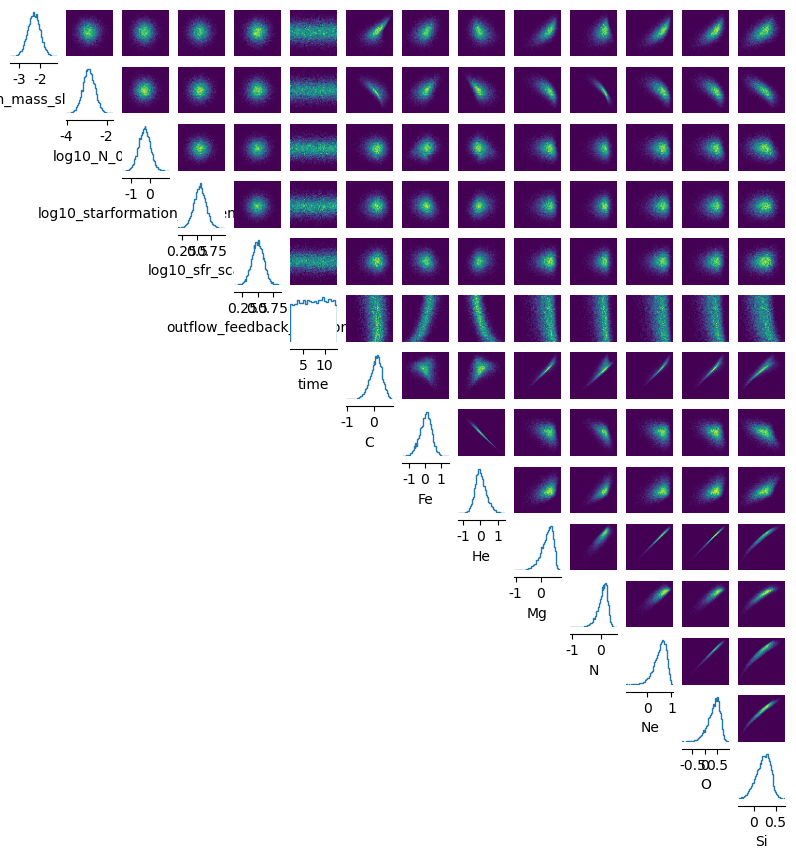

In [19]:
_ = pairplot(np.array(data[...,0]), labels=labels_in+labels_out)

In [52]:
def generate_data(n: int) -> Tuple[Array, Array]:
    theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=n)
    data = jnp.asarray(torch.cat([theta, x], axis=1).reshape(len(x), -1, 1))
    return  data

### 2) Setting up the diffusion process

We will use the VESDE i.e. the variance exploding stochastic differential equation. 

In [26]:
nodes_max = data.shape[1]
node_ids = jnp.arange(nodes_max)
key = jax.random.PRNGKey(0)

In [27]:
# VESDE 
T = 1.
T_min = 1e-2
sigma_min = 1e-3
sigma_max = 15.

p0 = Independent(Empirical(data), 1) # Empirical distribution of the data
sde = VESDE(p0, sigma_min=sigma_min , sigma_max=sigma_max)

# Scaling fn for the output of the score model
def output_scale_fn(t, x):
    scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
    return (1/scale * x).reshape(x.shape)

In [28]:
dim_value = 20      # Size of the value embedding
dim_id = 20         # Size of the node id embedding
dim_condition = 10  # Size of the condition embedding


def model(t: Array, x: Array, node_ids: Array, condition_mask:Array, edge_mask: Optional[Array]=None):
    """Simplified Simformer model.

    Args:
        t (Array): Diffusion time
        x (Array): Value of the nodes
        node_ids (Array): Id of the nodes
        condition_mask (Array): Condition state of the nodes
        edge_mask (Array, optional): Edge mask. Defaults to None.

    Returns:
        Array: Score estimate of p(x_t)
    """
    batch_size, seq_len, _ = x.shape
    condition_mask = condition_mask.astype(jnp.bool_).reshape(-1,seq_len, 1)
    node_ids = node_ids.reshape(-1,seq_len)
    t = t.reshape(-1,1, 1)
    
    # Diffusion time embedding net (here we use a Gaussian Fourier embedding)
    embedding_time = GaussianFourierEmbedding(64)  # Time embedding method
    time_embeddings = embedding_time(t)
    
    # Tokinization part --------------------------------------------------------------------------------

    embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)    # Value embedding net (here we just repeat the value)
    embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))   # Node id embedding nets (here we use a learnable random embedding vector)
    condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), init=hk.initializers.RandomNormal(stddev=0.5)) # Condition embedding (here we use a learnable random embedding vector)
    condition_embedding = condition_embedding * condition_mask # If condition_mask is 0, then the embedding is 0, otherwise it is the condition_embedding vector
    condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))
    
    # Embed inputs and broadcast
    value_embeddings = embedding_net_value(x)
    id_embeddings = embedding_net_id(node_ids)
    value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)
    
    # Concatenate embeddings (alternatively you can also add instead of concatenating)
    x_encoded = jnp.concatenate([value_embeddings, id_embeddings, condition_embedding], axis=-1)
    
    # Transformer part --------------------------------------------------------------------------------
    model = Transformer(num_heads=2, num_layers=2, attn_size=10, widening_factor=3) 
    
    # Encode - here we just use a transformer to transform the tokenized inputs into a latent representation
    h = model(x_encoded, context=time_embeddings, mask=edge_mask)

    # Decode - here we just use a linear layer to get the score estimate (we scale the output by the marginal std dev)
    out = hk.Linear(1)(h)
    out = output_scale_fn(t, out) # SDE dependent output scaling
    return out

In [29]:
# In Haiku, we need to initialize the model first, before we can use it.
init, model_fn = hk.without_apply_rng(hk.transform(model)) # Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument, hence is a "pure function")
params = init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))

In [30]:
# Here we can see the total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

Total number of parameters:  45994


{'embed': {'embeddings': (14, 20)},
 'gaussian_fourier_embedding': {'B': (33, 1)},
 'linear': {'b': (1,), 'w': (50, 1)},
 'transformer/layer_norm': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_1': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_2': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_3': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_4': {'offset': (50,), 'scale': (50,)},
 'transformer/linear': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_1': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_2': {'b': (50,), 'w': (64, 50)},
 'transformer/linear_3': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_4': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_5': {'b': (50,), 'w': (64, 50)},
 'transformer/multi_head_attention/key': {'b': (20,), 'w': (50, 20)},
 'transformer/multi_head_attention/linear': {'b': (50,), 'w': (20, 50)},
 'transformer/multi_head_attention/query': {'b': (20,), 'w': (50, 20)},
 'transformer/mult

### 4) The loss
Here we will show the variant which targets to learn:

* Correct joint $p(\theta,x_1, x_2)$
* Correct conditionals $p(\theta|x), p(x|\theta), ...$
* Correct marginals $p(\theta), p(x), ...$
    
Base loss is an **denoising score matching objective**:
$$ \mathcal{L}(\phi) = \mathbb{E}_{t \sim Unif(0,1)} \left[ \lambda(t) \mathbb{E}_{x_0, x_t \sim p(x_0)p(x_t|x_0)}\left[ || s_\phi(x_t, t) - \nabla_{x_t} \log p(x_t|x_0)||_2^2 \right] \right] $$
all the different *targets* will be implemented through masking out different things.

In [55]:
def weight_fn(t:Array):
    # MLE weighting
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def marginalize(rng: PRNGKey, edge_mask: Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

def loss_fn(params: dict, key: PRNGKey, batch_size:int= 1024):

    rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)
    
    # Generate data and random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    batch_xs = generate_data(batch_size) # n, T_max, 1

    # Node ids (can be subsampled but here we use all nodes)
    ids = node_ids
    

    # Condition mask -> randomly condition on some data.
    condition_mask = jax.random.bernoulli(rng_condition, 0.333, shape=(batch_xs.shape[0], batch_xs.shape[1]))
    condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
    condition_mask *= condition_mask_all_one # Avoid conditioning on all nodes -> nothing to train...
    condition_mask = condition_mask[..., None]
    # Alternatively you can also set the condition mask manually to specific conditional distributions.
    # condition_mask = jnp.zeros((3,), dtype=jnp.bool_)  # Joint mask
    # condition_mask = jnp.array([False, True, True], dtype=jnp.bool_)  # Posterior mask
    # condition_mask = jnp.array([True, False, False], dtype=jnp.bool_)  # Likelihod mask
    
    # You can also structure the base mask!
    edge_mask = jnp.ones((4*batch_size//5, batch_xs.shape[1],batch_xs.shape[1]), dtype=jnp.bool_) # Dense default mask 
    
    # Optional: Include marginal consistency
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size//5,)), edge_mask[0])
    edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask
    

    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = denoising_score_matching_loss(params, rng_sample, times, batch_xs, condition_mask, model_fn= model_fn, mean_fn=sde.marginal_mean, std_fn = sde.marginal_stddev, weight_fn=weight_fn,node_ids=ids, condition_mask=condition_mask, edge_mask=edge_masks)
    
    return loss


### 5) Training

Simple training loop (compatible with multiple GPUs, TPUs). Here simpy optimizing with Adam for a fixed amount of steps.

In [32]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@partial(jax.pmap, axis_name="num_devices")
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)
    
    loss = jax.lax.pmean(loss, axis_name="num_devices")
    grads = jax.lax.pmean(grads, axis_name="num_devices")
    
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [33]:
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)

In [74]:
key = jrandom.PRNGKey(0)
for _ in range(2):
    l = 0
    for i in range(1000):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey, (n_devices,)), replicated_opt_state)
        l += loss[0] /1000
    print(l)
params = jax.tree_map(lambda x: x[0], replicated_params)

127.83478
127.59988


In [75]:
replicated_params

{'embed': {'embeddings': Array([[[ 2.345, -0.166,  2.343, -1.89 , -0.11 , -1.806,  5.542, -0.321,
           -2.54 , -6.282,  1.286,  0.615, -3.828, -0.892, -3.001,  5.851,
            4.76 , -3.105, -1.533,  1.051],
          [ 1.28 , -3.111,  3.144,  6.073,  1.392, -2.957,  3.651, -3.053,
           -4.224, -5.043, -2.276, -0.587, -1.409, -2.42 , -2.662,  2.109,
           -4.332,  3.938,  2.232,  1.522],
          [-1.91 ,  2.437, -1.469,  0.156,  1.814,  6.793,  1.392,  0.823,
            0.366,  0.742, -0.323, -1.856,  0.317,  6.702,  2.048,  2.085,
           -4.297,  3.796,  1.096, -6.209],
          [-1.835,  4.717,  0.652,  1.227,  3.874,  1.653, -1.601, -3.292,
           -0.084, -1.923, -2.803,  1.708,  5.14 , -0.503, -2.568,  5.643,
            2.478, -6.836,  3.084,  0.899],
          [-3.487, -2.188,  1.55 , -0.721,  2.306, -1.759, -3.545, -1.401,
           -1.977,  2.587, -0.481, -1.44 , -2.064, -0.264, -0.553, -0.338,
            3.691,  4.251, -3.009,  1.875],
       

In [76]:
params

{'embed': {'embeddings': Array([[ 2.345, -0.166,  2.343, -1.89 , -0.11 , -1.806,  5.542, -0.321,
          -2.54 , -6.282,  1.286,  0.615, -3.828, -0.892, -3.001,  5.851,
           4.76 , -3.105, -1.533,  1.051],
         [ 1.28 , -3.111,  3.144,  6.073,  1.392, -2.957,  3.651, -3.053,
          -4.224, -5.043, -2.276, -0.587, -1.409, -2.42 , -2.662,  2.109,
          -4.332,  3.938,  2.232,  1.522],
         [-1.91 ,  2.437, -1.469,  0.156,  1.814,  6.793,  1.392,  0.823,
           0.366,  0.742, -0.323, -1.856,  0.317,  6.702,  2.048,  2.085,
          -4.297,  3.796,  1.096, -6.209],
         [-1.835,  4.717,  0.652,  1.227,  3.874,  1.653, -1.601, -3.292,
          -0.084, -1.923, -2.803,  1.708,  5.14 , -0.503, -2.568,  5.643,
           2.478, -6.836,  3.084,  0.899],
         [-3.487, -2.188,  1.55 , -0.721,  2.306, -1.759, -3.545, -1.401,
          -1.977,  2.587, -0.481, -1.44 , -2.064, -0.264, -0.553, -0.338,
           3.691,  4.251, -3.009,  1.875],
         [ 2.888,  1.0

In [77]:
params = jax.tree_map(lambda x: x[0], replicated_params)

### 6) Sampling from the joint and the marginals

For this we will implement a simple SDE-based sampler.

In [78]:
from functools import partial
from probjax.utils.sdeint import sdeint

condition_mask = jnp.zeros((nodes_max,))
condition_value = jnp.zeros((nodes_max,))

# Reverse SDE drift
def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])
    
    return f

# Reverse SDE diffusion
def diffusion_backward(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    b =  sde.diffusion(t,x) 
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

In [79]:

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

@partial(jax.jit, static_argnums=(1,3,7,8))
def sample_fn(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]
    
    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys


In [85]:
# Full joint estimation
samples = sample_fn(jrandom.PRNGKey(0), (10000,), node_ids, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)))

/var/folders/bl/y6h058c51nv6bzn1rdfnwrm40000gn/T/ipykernel_12623/1434269031.py:1: DeprecationWarning: you passed deprecated arguments **kwargs: ['diag_kind', 'color', 'linewidth'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig,axes = pairplot(np.array(samples[:,-1,:]), labels=labels_in+labels_out, diag_kind="kde", color="black", linewidth=2)


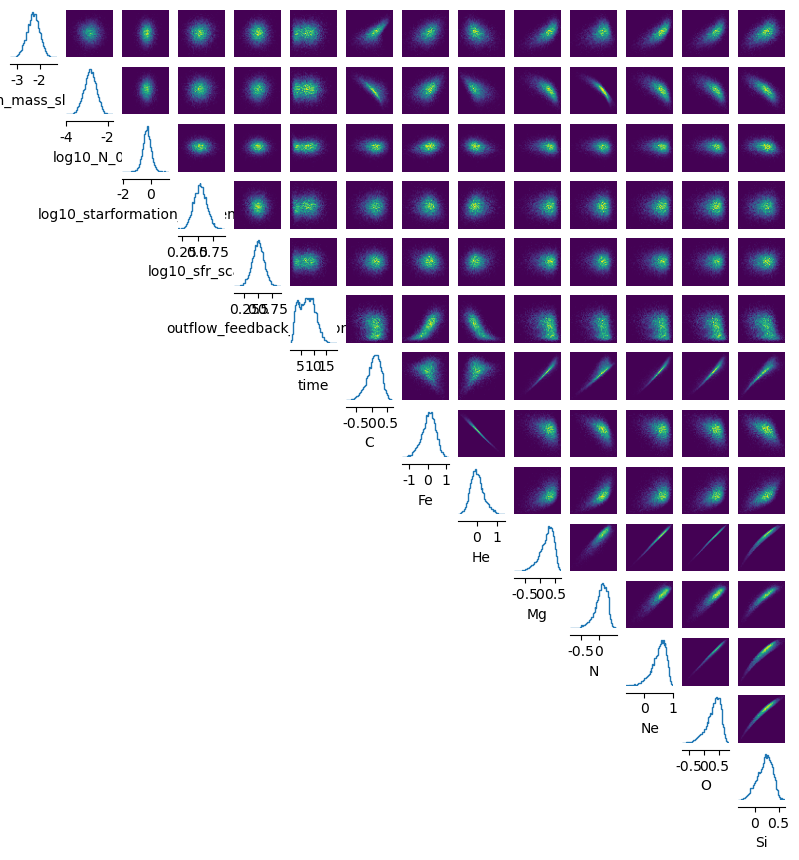

In [86]:

fig,axes = pairplot(np.array(samples[:,-1,:]), labels=labels_in+labels_out, diag_kind="kde", color="black", linewidth=2)


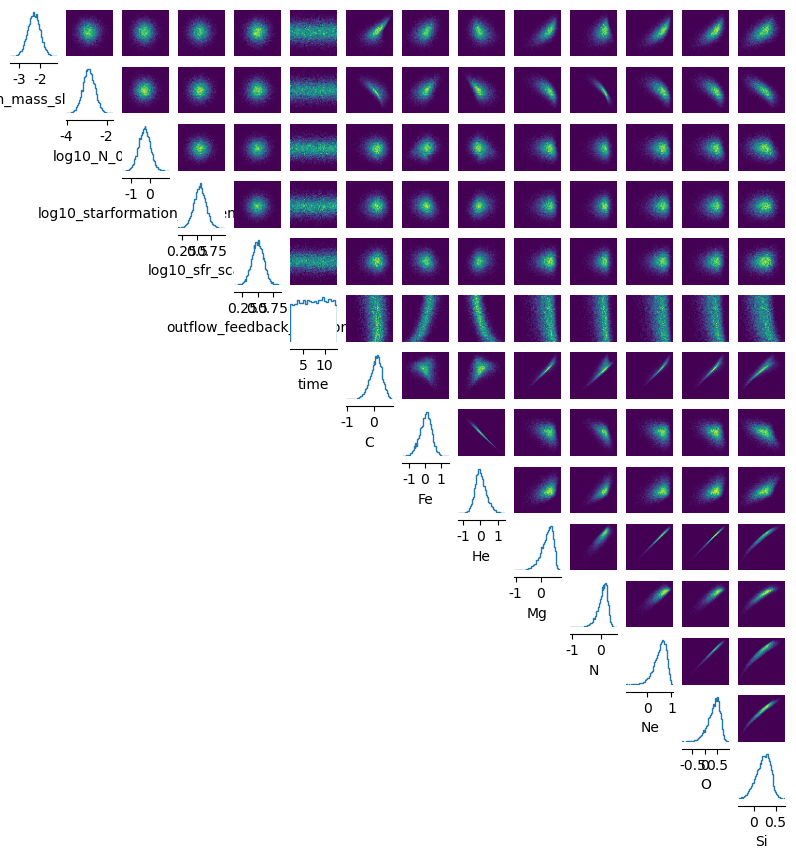

In [88]:
_ = pairplot(np.array(data[...,0]), labels=labels_in+labels_out)

/var/folders/bl/y6h058c51nv6bzn1rdfnwrm40000gn/T/ipykernel_12623/1246925543.py:1: DeprecationWarning: you passed deprecated arguments **kwargs: ['diag_kind', 'color', 'linewidth'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig,axes = pairplot(np.array(samples[:,1,:]), labels=labels_in+labels_out, diag_kind="kde", color="black", linewidth=2)


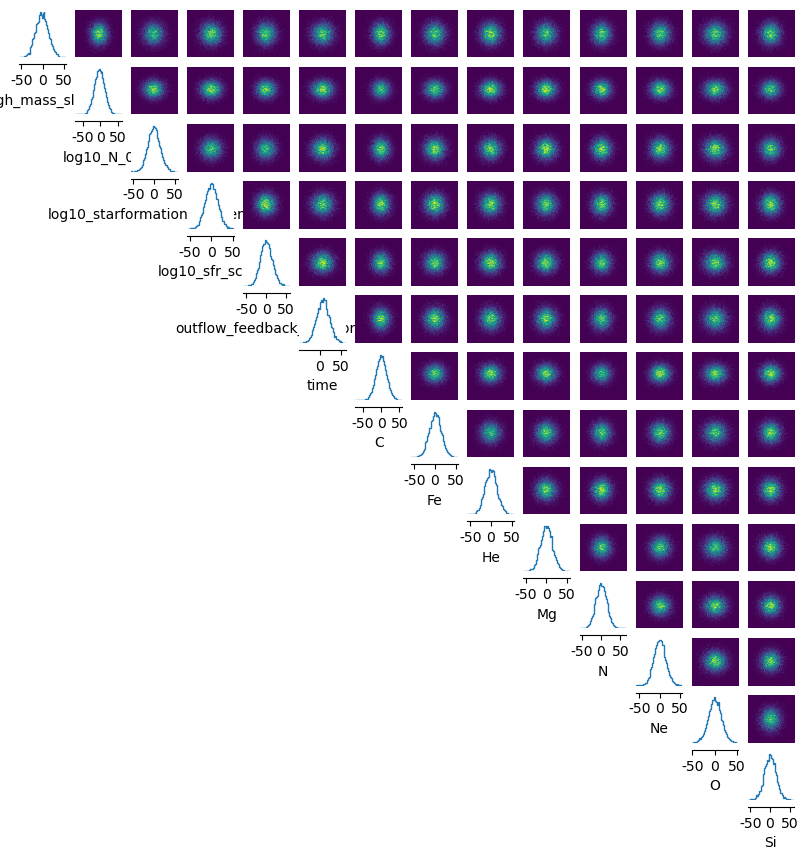

In [87]:

fig,axes = pairplot(np.array(samples[:,1,:]), labels=labels_in+labels_out, diag_kind="kde", color="black", linewidth=2)


In [71]:
samples[:,-1,:].shape

(10000, 14)

In [69]:
samples.shape

(10000, 500, 14)